In [18]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re

<h1>1. Dataset Exploration & Understanding</h1>

In [19]:
# number of partipants
'''
In the description there are
48 participants
'''

# Days recorded per participant
min_date = None
max_date = None

for file in os.listdir("./dataset/calendar/"):
    df = pd.read_csv(f"./dataset/calendar/{file}")
    if min_date == None and max_date == None:
        min_date = df['DATE'].min()
        max_date = df['DATE'].max()
    else:
        if df['DATE'].min() < min_date:
            min_date = df['DATE'].min()

        if df['DATE'].max() > max_date:
            max_date = df['DATE'].max()

print(f"Earliest Date: {min_date}")
print(f"Latest Date: {max_date}")
print()


# Demographic diversity (age, gender)

'''
48 undergrads and grad students
doesn't specify gender
'''

# Total datapoints and labels
 
total_datapoints = 0
total_labels = 0
for file in os.listdir("./dataset/sensing/gps/"):
    df = pd.read_csv(f"./dataset/sensing/gps/{file}")
    total_datapoints += df.shape[0]
    total_labels += len(df['provider'].unique())

print(f"Total Datapoints: {total_datapoints}")
print(f"Total Labels: {total_labels}")
print()

# Datapoints per label

per_label = pd.Series(dtype="float64")  

for file in os.listdir("./dataset/sensing/gps/"):
    df = pd.read_csv(f"./dataset/sensing/gps/{file}")

    counts = (
        df.groupby("provider", dropna=False)
          .agg(rows=("provider", 'size'))
    )

    per_label = per_label.add(counts['rows'], fill_value=0)

per_label = per_label.astype(int).sort_values(ascending=False)
print(per_label)

# Input streams (accelerometer, gyro, annotations, etc.) 

'''
time
provider
network_type
accuracy
latitude
longitude
altitude
bearing
speed
travelstate
'''

Earliest Date: 03/27/2013
Latest Date: 6/8/2013

Total Datapoints: 202877
Total Labels: 117

provider
wifi    187613
NaN      10744
cell      4520
dtype: int32


'\ntime\nprovider\nnetwork_type\naccuracy\nlatitude\nlongitude\naltitude\nbearing\nspeed\ntravelstate\n'

<h1>2. Annotation & Signal Exploration</h1>

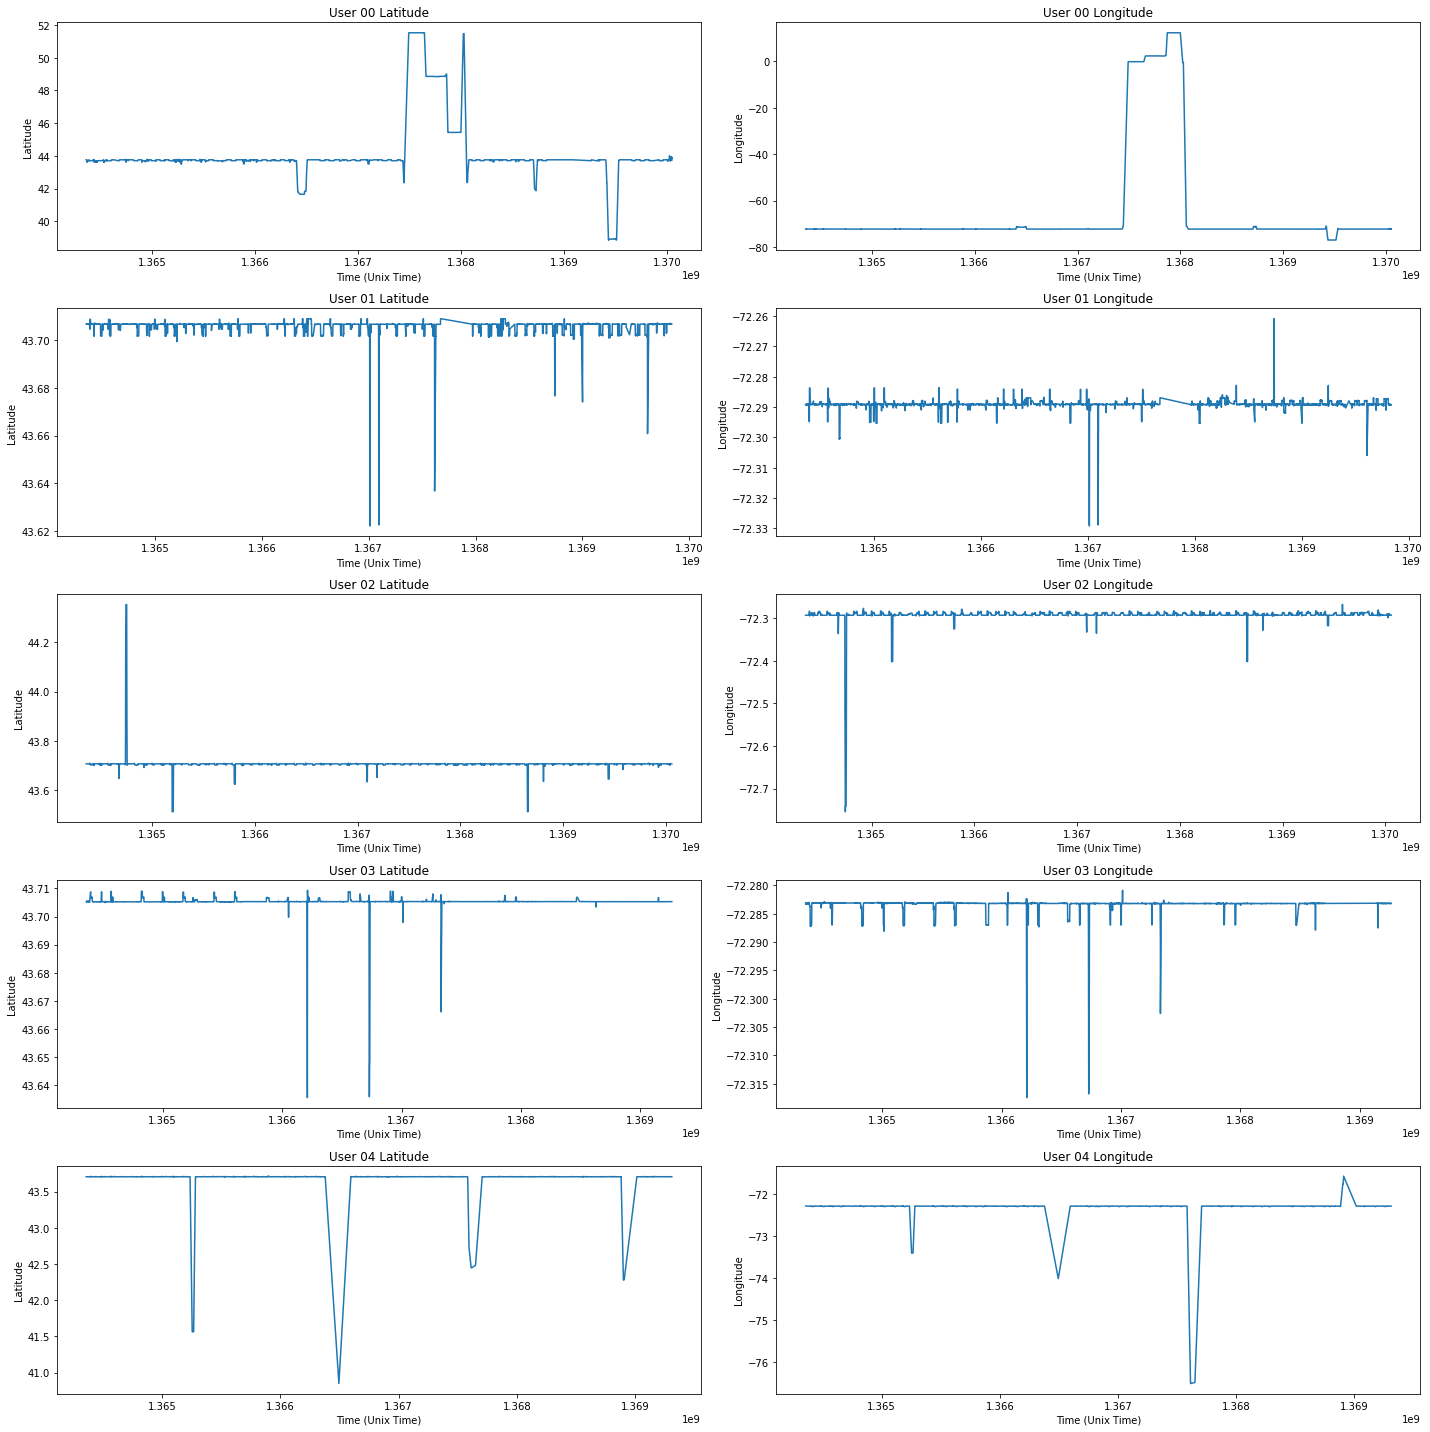

In [20]:
# General latitude and longitude plots
fig, axes = plt.subplots(5, 2, figsize=(20,20))

for i,file in enumerate(os.listdir("./dataset/sensing/gps/")):
    df = pd.read_csv(f"./dataset/sensing/gps/{file}", index_col=False)
    user = re.findall(r'\d+', file)[0]
    axes[i][0].plot(df['time'], df['latitude'])
    axes[i][0].set_title('User ' + str(user) + ' Latitude')
    axes[i][0].set_xlabel('Time (Unix Time)')
    axes[i][0].set_ylabel('Latitude')
    axes[i][1].plot(df['time'], df['longitude'])
    axes[i][1].set_title('User ' + str(user) + ' Longitude')  
    axes[i][1].set_xlabel('Time (Unix Time)')
    axes[i][1].set_ylabel('Longitude')  

    if i == 4:  # limit to first 5 users
        break

plt.tight_layout()
plt.show()

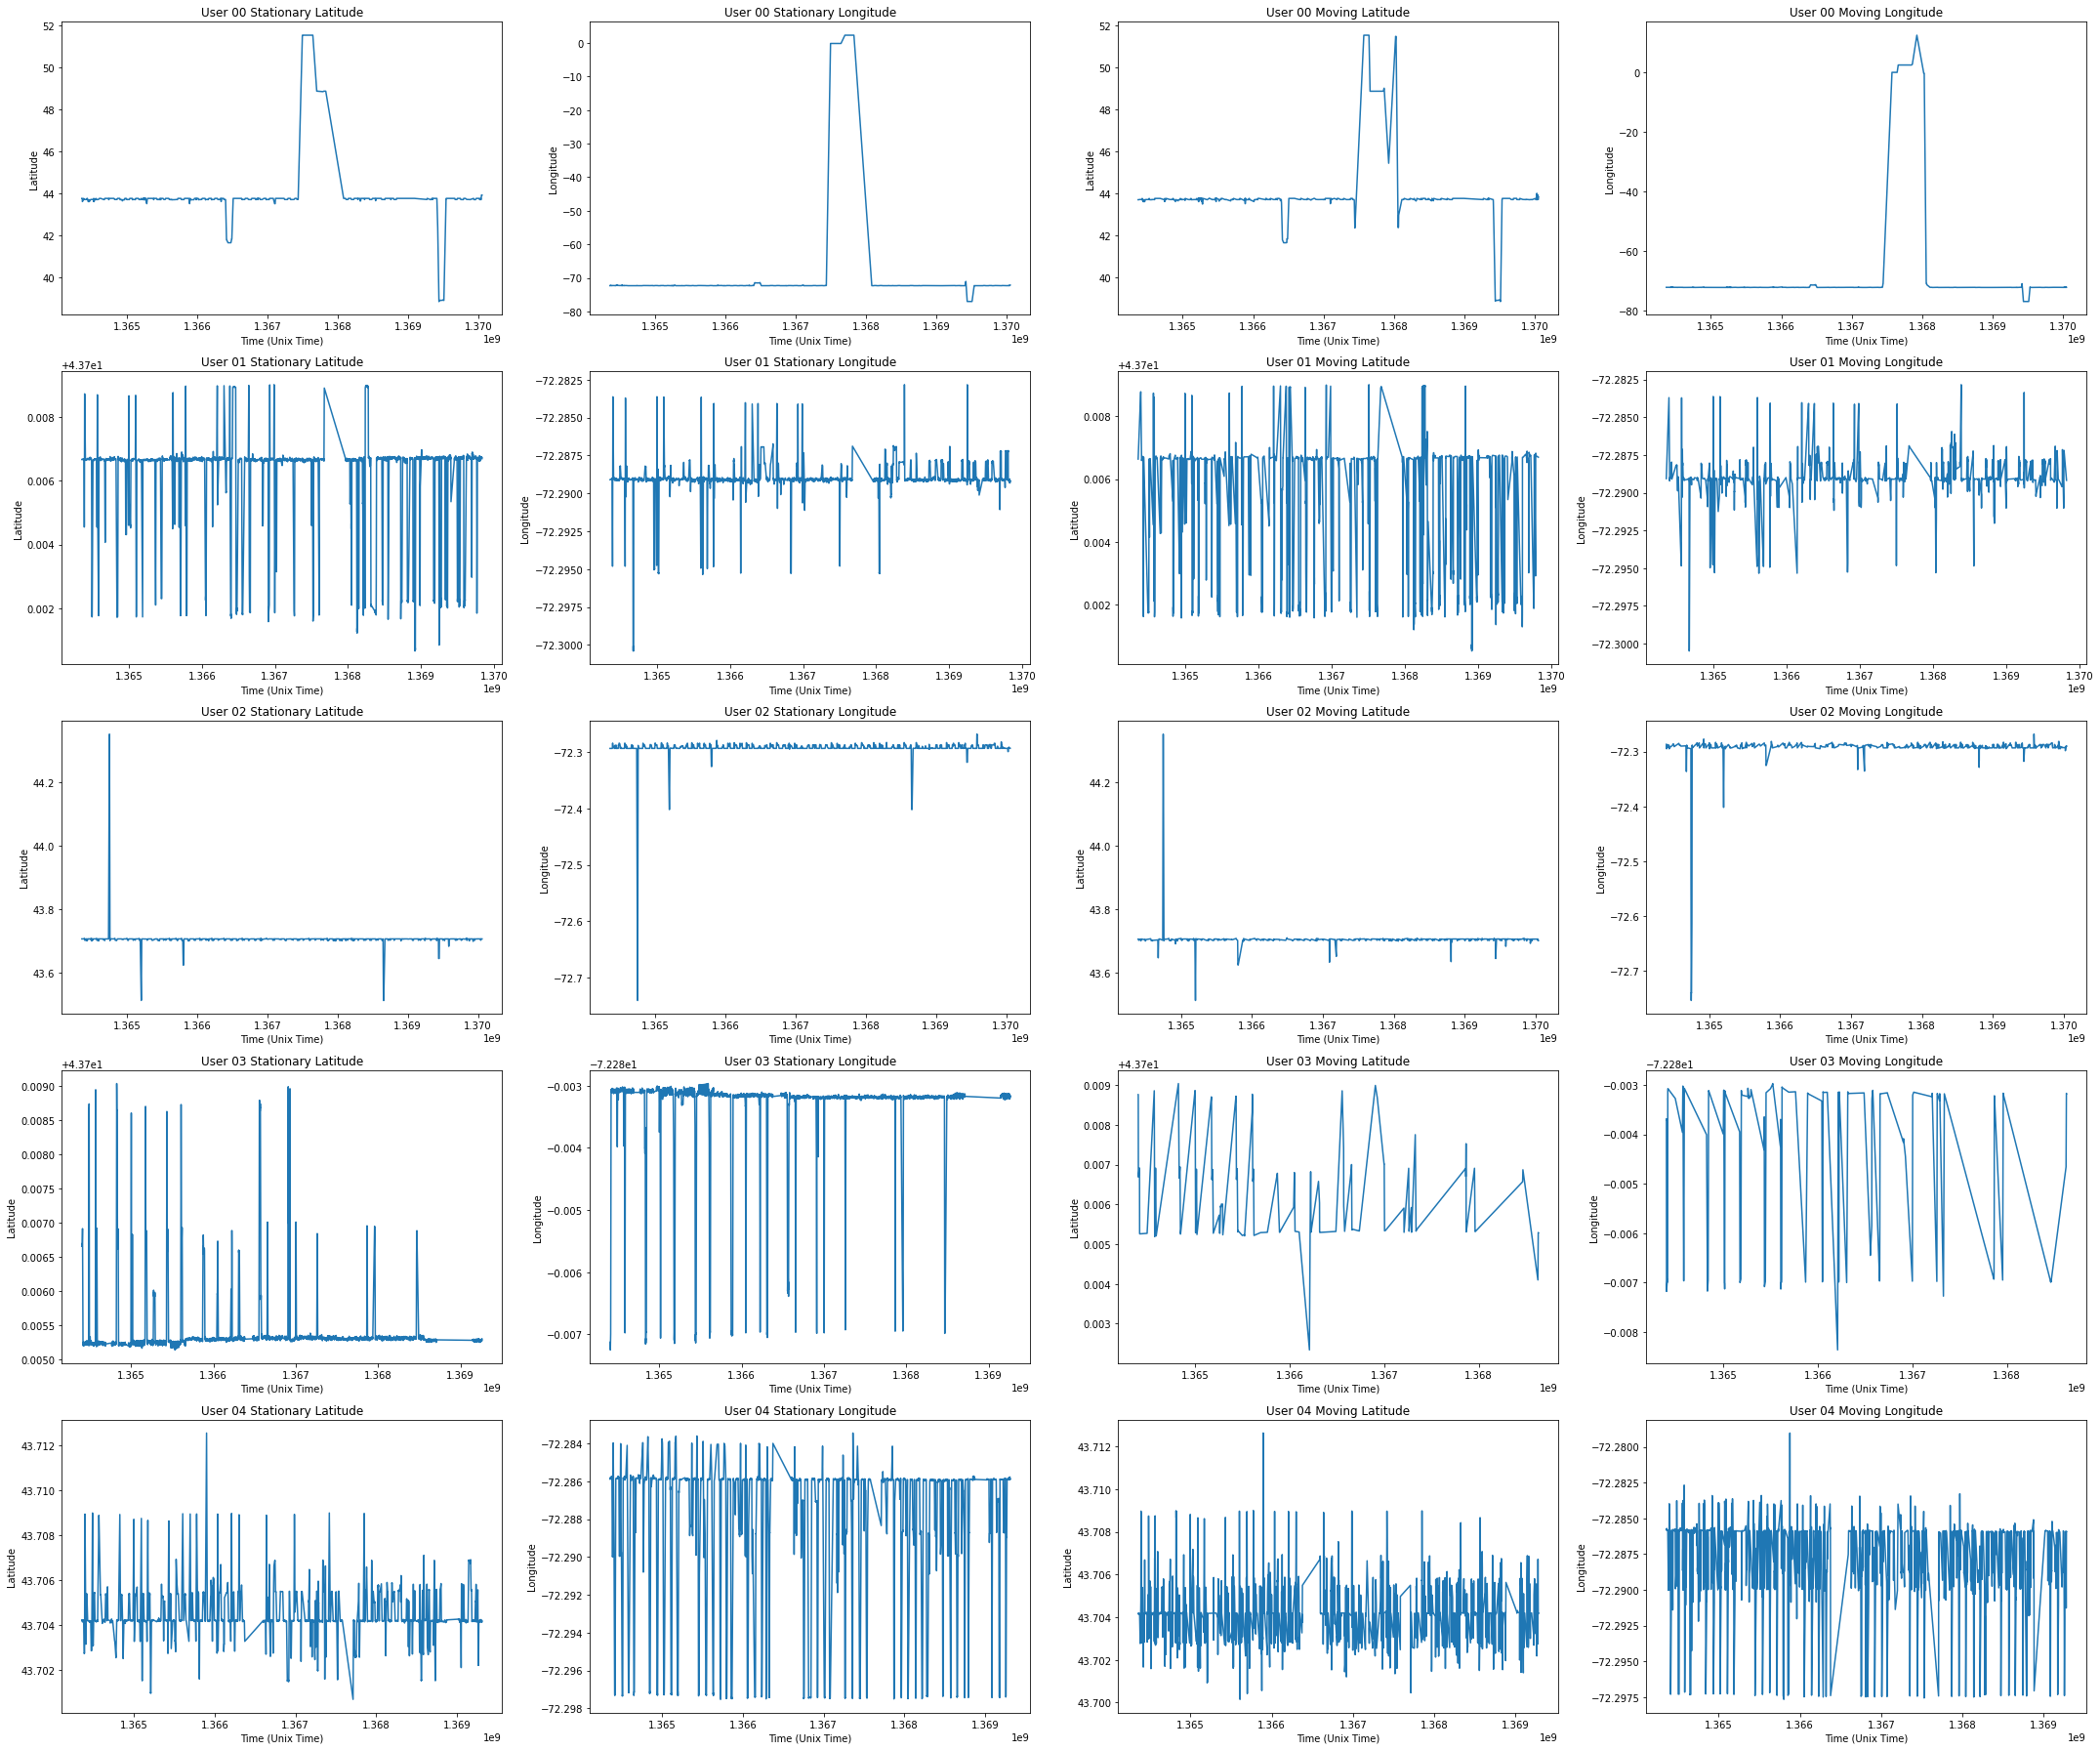

In [21]:
# Longitude and latitude plots based on travel state

fig, axes = plt.subplots(5, 4, figsize=(30,25))

for i,file in enumerate(os.listdir("./dataset/sensing/gps/")):
    df = pd.read_csv(f"./dataset/sensing/gps/{file}", index_col=False)
    user = re.findall(r'\d+', file)[0]
    stationary = df[df['travelstate'] == 'stationary']
    axes[i][0].plot(stationary['time'], stationary['latitude'])
    axes[i][0].set_title('User ' + str(user) + ' Stationary Latitude')
    axes[i][0].set_xlabel('Time (Unix Time)')
    axes[i][0].set_ylabel('Latitude')
    axes[i][1].plot(stationary['time'], stationary['longitude'])
    axes[i][1].set_title('User ' + str(user) + ' Stationary Longitude') 
    axes[i][1].set_xlabel('Time (Unix Time)')
    axes[i][1].set_ylabel('Longitude')

    moving = df[df['travelstate'] == 'moving']
    axes[i][2].plot(moving['time'], moving['latitude'])
    axes[i][2].set_title('User ' + str(user) + ' Moving Latitude')
    axes[i][2].set_xlabel('Time (Unix Time)')
    axes[i][2].set_ylabel('Latitude')
    axes[i][3].plot(moving['time'], moving['longitude'])
    axes[i][3].set_title('User ' + str(user) + ' Moving Longitude') 
    axes[i][3].set_xlabel('Time (Unix Time)')
    axes[i][3].set_ylabel('Longitude')
      

    if i == 4:  # preventing the graph from being too long since 2 travel states * 2 coords (lat/long) * 49 user graphs
        break 

plt.tight_layout()
plt.show()

<h1>3. Signal Preprocessing</h1>

In [22]:
# Resampling to uniform frequency

resampled_df = pd.DataFrame()

for path in os.listdir("./dataset/sensing/gps"):
    df = pd.read_csv(f"./dataset/sensing/gps/{file}", sep=",", index_col=False, skipinitialspace=True)

    df["time"] = pd.to_numeric(df["time"], errors="coerce")
    df["timestamp"] = pd.to_datetime(df["time"], unit="s", utc=True, errors="coerce")

    df = (df.dropna(subset=["timestamp"])
            .sort_values("timestamp")
            .drop_duplicates("timestamp"))

    # Does a 1 min resample
    # Picks the first record within each min
    g = (df.set_index("timestamp")
           .resample("1min")
           .first()
           .reset_index())

    g = g.dropna(subset=["time"])

    resampled_df = pd.concat([resampled_df, g], ignore_index=True)

# Makes sure there is no duplicates for each min
# If there is a duplicate then the earliest timestamp is kept
resampled_df = (resampled_df.sort_values("timestamp").drop_duplicates(subset=["timestamp"], keep="first"))

resampled_df

,timestamp,time,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate
0,2013-03-27 04:06:00+00:00,1.364357e+09,network,wifi,27.000,43.704217,-72.285881,0.0,0.0,0.0,stationary
118273,2013-03-27 04:26:00+00:00,1.364358e+09,network,wifi,33.000,43.704169,-72.285786,0.0,0.0,0.0,moving
125442,2013-03-27 04:46:00+00:00,1.364360e+09,network,wifi,31.500,43.704192,-72.285832,0.0,0.0,0.0,stationary
118275,2013-03-27 05:06:00+00:00,1.364361e+09,network,wifi,25.000,43.704200,-72.285841,0.0,0.0,0.0,stationary
17924,2013-03-27 05:26:00+00:00,1.364362e+09,network,wifi,22.000,43.704196,-72.285842,0.0,0.0,0.0,moving
...,...,...,...,...,...,...,...,...,...,...,...
35835,2013-05-23 10:37:00+00:00,1.369305e+09,network,wifi,26.914,43.704177,-72.285882,0.0,0.0,0.0,stationary
121852,2013-05-23 10:57:00+00:00,1.369307e+09,network,wifi,49.750,43.704159,-72.285766,0.0,0.0,0.0,stationary
89597,2013-05-23 11:17:00+00:00,1.369308e+09,network,wifi,50.056,43.704117,-72.285825,0.0,0.0,0.0,stationary
86014,2013-05-23 11:37:00+00:00,1.369309e+09,network,wifi,24.741,43.704153,-72.285911,0.0,0.0,0.0,stationary


In [23]:
# Apply filtering (noise reduction)

filtered_df = resampled_df

# Noise reduction on the lat and lon values
filtered_df["filtered_latitude"]  = filtered_df["latitude"].rolling(3, center=True, min_periods=1).median()
filtered_df["filtered_longitude"] = filtered_df["longitude"].rolling(3, center=True, min_periods=1).median()

filtered_df.head(10)

,timestamp,time,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate,filtered_latitude,filtered_longitude
0,2013-03-27 04:06:00+00:00,1.364357e+09,network,wifi,27.0,43.704217,-72.285881,0.0,0.0,0.0,stationary,43.704193,-72.285834
118273,2013-03-27 04:26:00+00:00,1.364358e+09,network,wifi,33.0,43.704169,-72.285786,0.0,0.0,0.0,moving,43.704192,-72.285832
125442,2013-03-27 04:46:00+00:00,1.364360e+09,network,wifi,31.5,43.704192,-72.285832,0.0,0.0,0.0,stationary,43.704192,-72.285832
118275,2013-03-27 05:06:00+00:00,1.364361e+09,network,wifi,25.0,43.704200,-72.285841,0.0,0.0,0.0,stationary,43.704196,-72.285841
17924,2013-03-27 05:26:00+00:00,1.364362e+09,network,wifi,22.0,43.704196,-72.285842,0.0,0.0,0.0,moving,43.704196,-72.285841
75269,2013-03-27 05:46:00+00:00,1.364363e+09,network,wifi,31.5,43.704175,-72.285804,0.0,0.0,0.0,moving,43.704175,-72.285804
17926,2013-03-27 06:06:00+00:00,1.364364e+09,network,wifi,27.0,43.704139,-72.285706,0.0,0.0,0.0,moving,43.704139,-72.285763
100359,2013-03-27 06:26:00+00:00,1.364366e+09,network,wifi,28.0,43.704131,-72.285763,0.0,0.0,0.0,stationary,43.704139,-72.285763
89608,2013-03-27 06:46:00+00:00,1.364367e+09,network,wifi,27.0,43.704165,-72.285778,0.0,0.0,0.0,stationary,43.704165,-72.285778
136201,2013-03-27 07:06:00+00:00,1.364368e+09,network,wifi,31.5,43.704175,-72.285807,0.0,0.0,0.0,moving,43.704174,-72.285792


In [24]:
src = filtered_df.copy().sort_values("timestamp")

lat_col = "filtered_latitude"  if "filtered_latitude"  in src.columns else "latitude"
lon_col = "filtered_longitude" if "filtered_longitude" in src.columns else "longitude"

full_idx = pd.date_range(
    src["timestamp"].min().floor("min"),
    src["timestamp"].max().ceil("min"),
    freq="1min", tz="UTC"
)

dfi = (src[["timestamp", lat_col, lon_col]]
         .rename(columns={lat_col: "lat_obs", lon_col: "lon_obs"})
         .set_index("timestamp")
         .reindex(full_idx))

# If the gap between the time is more than 10mins then it is ignored
# gap_min = 10
# lat_i = dfi["lat_obs"].interpolate(method="time", limit=gap_min, limit_direction="both")
# lon_i = dfi["lon_obs"].interpolate(method="time", limit=gap_min, limit_direction="both")

lat_i = dfi["lat_obs"].interpolate(method="time", limit_direction="both")
lon_i = dfi["lon_obs"].interpolate(method="time", limit_direction="both")

lat_final = dfi["lat_obs"].where(dfi["lat_obs"].notna(), lat_i)
lon_final = dfi["lon_obs"].where(dfi["lon_obs"].notna(), lon_i)

# Base 1-min timeline with unified lat/lon
interploated_df = (pd.DataFrame({
        "timestamp": full_idx,
        "latitude":  lat_final,
        "longitude": lon_final
    })
    .reset_index(drop=True)
)

other_columns = ["provider","network_type","accuracy","altitude","bearing","speed","travelstate"]
columns = [c for c in other_columns if c in src.columns]

# If the closest column is not 10min away then it is set as a nan value 
# extra_columns = pd.merge_asof(
#     interploated_df.sort_values("timestamp"),
#     src[["timestamp"] + columns].sort_values("timestamp"),
#     on="timestamp",
#     direction="nearest",
#     tolerance=pd.Timedelta("10min")
# )


extra_columns = pd.merge_asof(
    interploated_df.sort_values("timestamp"),
    src[["timestamp"] + columns].sort_values("timestamp"),
    on="timestamp",
    direction="nearest"
)

interploated_df = extra_columns.sort_values("timestamp").reset_index(drop=True)

interploated_df.head()


,timestamp,latitude,longitude,provider,network_type,accuracy,altitude,bearing,speed,travelstate
0,2013-03-27 04:06:00+00:00,43.704193,-72.285834,network,wifi,27.0,0.0,0.0,0.0,stationary
1,2013-03-27 04:07:00+00:00,43.704193,-72.285834,network,wifi,27.0,0.0,0.0,0.0,stationary
2,2013-03-27 04:08:00+00:00,43.704193,-72.285833,network,wifi,27.0,0.0,0.0,0.0,stationary
3,2013-03-27 04:09:00+00:00,43.704193,-72.285833,network,wifi,27.0,0.0,0.0,0.0,stationary
4,2013-03-27 04:10:00+00:00,43.704193,-72.285833,network,wifi,27.0,0.0,0.0,0.0,stationary


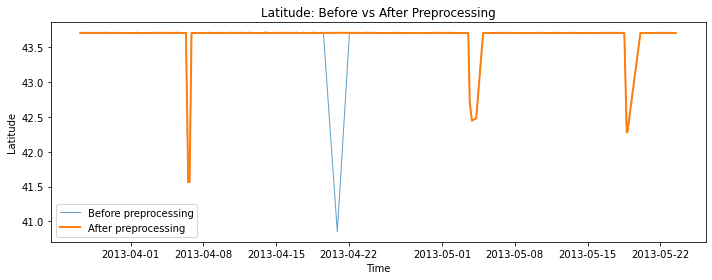

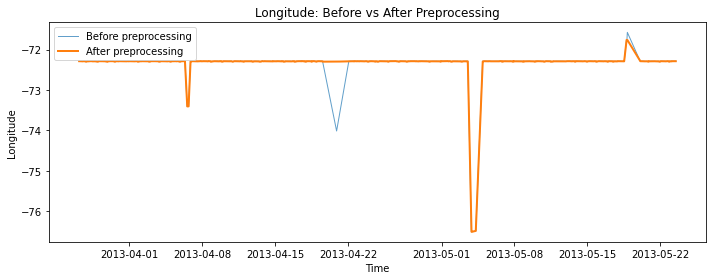

In [25]:
plt.figure(figsize=(10,4))
plt.plot(resampled_df["timestamp"], resampled_df["latitude"], label="Before preprocessing", linewidth=1, alpha=0.7)
plt.plot(interploated_df["timestamp"], interploated_df["latitude"], label="After preprocessing", linewidth=2)
plt.title("Latitude: Before vs After Preprocessing")
plt.xlabel("Time")
plt.ylabel("Latitude")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(resampled_df["timestamp"], resampled_df["longitude"], label="Before preprocessing", linewidth=1, alpha=0.7)
plt.plot(interploated_df["timestamp"], interploated_df["longitude"], label="After preprocessing", linewidth=2)
plt.title("Longitude: Before vs After Preprocessing")
plt.xlabel("Time")
plt.ylabel("Longitude")
plt.legend()
plt.tight_layout()
plt.show()


<h1>4. Windowing Strategies</h1>

• Implement one of two strategies:

 – Fixed/Sliding Windows: test ≥10 window sizes – 1.0

 – Event-Based/Dynamic Windows: propose and justify new segmentation – 1.0

• Provide rationale for chosen strategy (accuracy vs. interpretability) – 0.5

In [26]:
print('Number of days in data:',len(interploated_df['timestamp'].dt.date.unique()))

# windows = 1 day since there are 58 separate days
fixedWindow = {}

for day, dataf in interploated_df.groupby(interploated_df['timestamp'].dt.date):
    fixedWindow[day] = dataf

print('Number of fixed windows:',len(fixedWindow))

# sliding window = 1 day windows, 50% overlap
slidingWindow = {}
size = pd.Timedelta(days=1)
start = interploated_df['timestamp'].min()
index = 0
while start < interploated_df['timestamp'].max():
    end = start + size
    window = interploated_df[(interploated_df['timestamp'] >= start) & (interploated_df['timestamp'] < end)]
    slidingWindow[index] = window
    start += size / 2 # 50% overlap
    index += 1

print('Number of sliding windows:',len(slidingWindow))

Number of days in data: 58
Number of fixed windows: 58
Number of sliding windows: 115


In [27]:
# Dynamic window; splitting based on travel state (i.e. window 1 = first batch of stationary, window 2 = first batch of walking, window 3 = second batch of stationary, etc)

transitions = (interploated_df['travelstate'] != interploated_df['travelstate'].shift()).cumsum()
dynamicWindows = {index: window for index, window in interploated_df.groupby(transitions)}

# 7928 windows
dynamicWindows

{1:                    timestamp   latitude  longitude provider network_type  \
 0  2013-03-27 04:06:00+00:00  43.704193 -72.285834  network         wifi   
 1  2013-03-27 04:07:00+00:00  43.704193 -72.285834  network         wifi   
 2  2013-03-27 04:08:00+00:00  43.704193 -72.285833  network         wifi   
 3  2013-03-27 04:09:00+00:00  43.704193 -72.285833  network         wifi   
 4  2013-03-27 04:10:00+00:00  43.704193 -72.285833  network         wifi   
 5  2013-03-27 04:11:00+00:00  43.704193 -72.285833  network         wifi   
 6  2013-03-27 04:12:00+00:00  43.704193 -72.285833  network         wifi   
 7  2013-03-27 04:13:00+00:00  43.704193 -72.285833  network         wifi   
 8  2013-03-27 04:14:00+00:00  43.704193 -72.285833  network         wifi   
 9  2013-03-27 04:15:00+00:00  43.704193 -72.285833  network         wifi   
 10 2013-03-27 04:16:00+00:00  43.704193 -72.285833  network         wifi   
 
     accuracy  altitude  bearing  speed travelstate  
 0       27.0    

In [28]:
# just testing to see how many dynamic windows for just 1 user
for i,file in enumerate(os.listdir("./dataset/sensing/gps/")):
    df = pd.read_csv(f"./dataset/sensing/gps/{file}", index_col=False)
    transitions = (df['travelstate'] != df['travelstate'].shift()).cumsum()
    dynamicWindows = {index: window for index, window in df.groupby(transitions)}
    break

len(dynamicWindows)

1094

<h1>5. Feature Extraction & Analysis</h1>

<h1>6. Modeling & Evaluation</h1>

• Implement classical ML models (Decision Tree, SVM, Naive Bayes, Random Forest, AdaBoost, XGBoost) – 1.0

• Document methodology (feature selection, model training, evaluation design) – 1.0

• Evaluate with standard splits (80/20, 70/30): precision, recall, accuracy, F1-macro – 1.0

• Include confusion matrices, error analysis, and member contributions – 0.5

• Write dataset, methodology, and results in Overleaf template (with tables and figures) – 0.5

In [29]:
#!pip install xgboost

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

Decision Tree Accuracy: 0.8557705048363589
              precision    recall  f1-score   support

      moving       0.85      0.83      0.84      6845
  stationary       0.86      0.88      0.87      8249

    accuracy                           0.86     15094
   macro avg       0.85      0.85      0.85     15094
weighted avg       0.86      0.86      0.86     15094



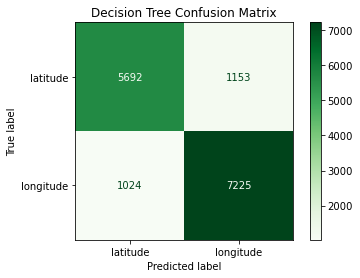

In [30]:
interploated_df = interploated_df.dropna(subset=['travelstate'])
X = interploated_df[['latitude', 'longitude']]
y = interploated_df['travelstate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# no max depth: 84.91%, 84.27%
# max depth 5: 76.86%
# 10: 81.03%
# 20: 85.35%, 85.34%, 85.18%, 85.63%
# 30: 84.58%

tree = DecisionTreeClassifier(max_depth=20)
tree.fit(X_train_scaled, y_train)
y_pred = tree.predict(X_test_scaled)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['latitude', 'longitude'])
disp.plot(cmap='Greens')
plt.title("Decision Tree Confusion Matrix")
plt.show()

SVM Accuracy: 0.6800053001192526
              precision    recall  f1-score   support

      moving       0.65      0.63      0.64      6845
  stationary       0.70      0.72      0.71      8249

    accuracy                           0.68     15094
   macro avg       0.68      0.68      0.68     15094
weighted avg       0.68      0.68      0.68     15094



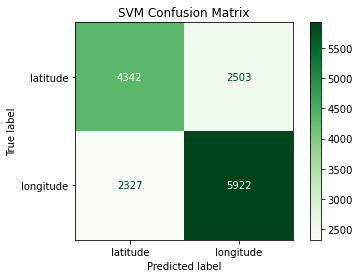

In [31]:
# rbf: 53.13%
# linear: 56.21%
# poly: 56.51% (like a minute faster too)
# sigmoid: 68.04%


svm = SVC(kernel="sigmoid")
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)
print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['latitude', 'longitude'])
disp.plot(cmap='Greens')
plt.title("SVM Confusion Matrix")
plt.show()

Naive Bayes Accuracy: 0.5629389161256129
              precision    recall  f1-score   support

      moving       0.89      0.04      0.08      6845
  stationary       0.56      1.00      0.71      8249

    accuracy                           0.56     15094
   macro avg       0.72      0.52      0.40     15094
weighted avg       0.71      0.56      0.43     15094



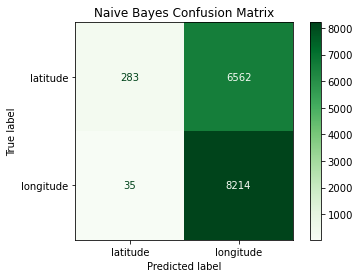

In [32]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred = nb.predict(X_test_scaled)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['latitude', 'longitude'])
disp.plot(cmap='Greens')
plt.title("Naive Bayes Confusion Matrix")
plt.show()

Random Forest Accuracy: 0.8729958924075791
              precision    recall  f1-score   support

      moving       0.86      0.86      0.86      6845
  stationary       0.88      0.88      0.88      8249

    accuracy                           0.87     15094
   macro avg       0.87      0.87      0.87     15094
weighted avg       0.87      0.87      0.87     15094



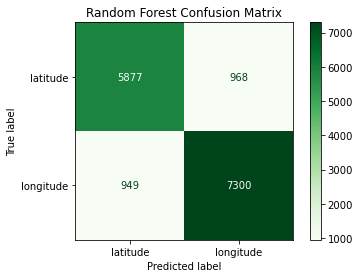

In [33]:
# n_estimators 100: 87.5%, 87.29%, 87.22%, 87.25%
# 200: 87.99%, 87.28%, 87.42%, 87.33%
# 300: 87.68%, 87.38%, 87.39%
# 500: 87.44%, 87.38%, 87.43%
# 1000: 87.32%, 87.25%

forest = RandomForestClassifier(n_estimators=200)
forest.fit(X_train_scaled, y_train)
y_pred = forest.predict(X_test_scaled)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['latitude', 'longitude'])
disp.plot(cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.show()

AdaBoost Accuracy: 0.7809725718828674
              precision    recall  f1-score   support

      moving       0.79      0.70      0.74      6845
  stationary       0.77      0.85      0.81      8249

    accuracy                           0.78     15094
   macro avg       0.78      0.77      0.78     15094
weighted avg       0.78      0.78      0.78     15094



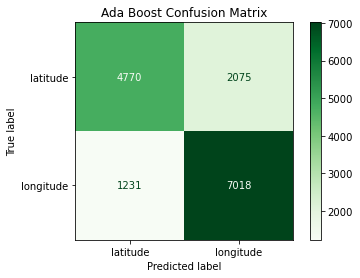

In [34]:
# default learning rate 1
# n_estimators 100: 76.28%
# 200: 77.09%
# 300: 77.54%, 76.56%
# 500: 76.76%, 77.41%
# 1000: 77.50%, 77.30%
# 2000: 78.4%
# 3000: 79.56%, 79.57%
# 5000: 78.61%

# learning rate 0.5
# 100: 75%
# 300: 75.91%

# learning rate 2
# 300: 32.85%

# learning rate 0.1
# 300: 75.28
# 200: 75.02%

ada = AdaBoostClassifier(n_estimators=3000)
ada.fit(X_train_scaled, y_train)
y_pred = ada.predict(X_test_scaled)
print("AdaBoost Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['latitude', 'longitude'])
disp.plot(cmap='Greens')
plt.title("Ada Boost Confusion Matrix")
plt.show()

In [35]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

XGBoost Accuracy: 0.8330462435404796
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      6845
           1       0.84      0.86      0.85      8249

    accuracy                           0.83     15094
   macro avg       0.83      0.83      0.83     15094
weighted avg       0.83      0.83      0.83     15094



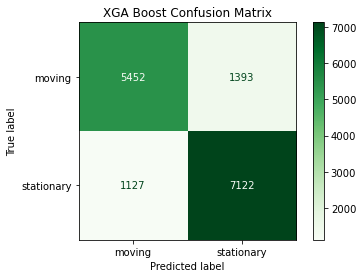

In [36]:
# n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss' 80.75%
# n_estimators=200, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss' 82.03%, 82.06%
# n_estimators=500, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss' 83.17%
# n_estimators=1000, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss' 83.34%

# n_estimators=1000, learning_rate=0.5, eval_metric='logloss' 82.52%, 83.13%
# n_estimators=500, learning_rate=0.5, eval_metric='logloss' 83.42%, 83.42%
# n_estimators=200, learning_rate=0.5, eval_metric='logloss' 83.50%, 83.72%
# n_estimators=100, learning_rate=0.5, eval_metric='logloss' 83.14%

# n_estimators=100, learning_rate=1, eval_metric='logloss' 82.77%
# n_estimators=200, learning_rate=1, eval_metric='logloss' 83.36%
# n_estimators=500, learning_rate=1, eval_metric='logloss' 82.31%

xgb = XGBClassifier(n_estimators=200, learning_rate=0.5, eval_metric='logloss')
xgb.fit(X_train_scaled, y_train)
y_pred = xgb.predict(X_test_scaled)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Greens')
plt.title("XGA Boost Confusion Matrix")
plt.show()